In [6]:
SOT = 'sot'
EOT = 'eot'
PAD = 0

max_keywords = 10

embedding_dim = 128
hidden_size = 128
encoder_layer_size = 1
learning_late = 0.001
dropout = 0.4

epochs = 5
batch_size = 1

In [7]:
import pickle

try:
    with open('crawling/news.pickle', 'rb') as f:
        articles = pickle.load(f)
except FileNotFoundError:
    with open('../crawling/news.pickle', 'rb') as f:
        articles = pickle.load(f)


In [8]:
bodies = articles['body'].to_list()

In [9]:
import re

sentences = []
for body in bodies:
    for sentence in body.split('.'):
        if not re.match('.*[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9 ].*', sentence):
            sentences.append(sentence)

In [10]:
from konlpy.tag import Okt

okt = Okt()

data = [(okt.nouns(sentence), okt.morphs(sentence)) for sentence in sentences]
data = [(keywords, sentence) for keywords, sentence in data
        if 0 < len(keywords) <= max_keywords]

data_keywords = [keywords for keywords, _ in data]
data_sentences = [[SOT] + sentence + [EOT] for _, sentence in data]

max_sentence_morphemes = max([len(sentence) for sentence in data_sentences])

In [11]:
def remove_overlaps(keywords):
    result = []
    for keyword in keywords:
        if keyword not in result:
            result.append(keyword)
    return result

data_keywords = [remove_overlaps(keywords) for keywords in data_keywords]

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_sentences)
tokenizer.index_word[PAD] = PAD

num_of_morphemes = len(tokenizer.word_counts) + 1

keywords_sequences = tokenizer.texts_to_sequences(data_keywords)
sentence_sequences = tokenizer.texts_to_sequences(data_sentences)

In [13]:
def padding(sequence, max_len):
    return sequence + [PAD] * (max_len - len(sequence))

keywords_sequences = [padding(seq, max_keywords) for seq in keywords_sequences]
sentence_sequences = [padding(seq, max_sentence_morphemes) for seq in sentence_sequences]

In [14]:
import numpy as np

keywords = np.array(keywords_sequences)
sentences = np.array(sentence_sequences)

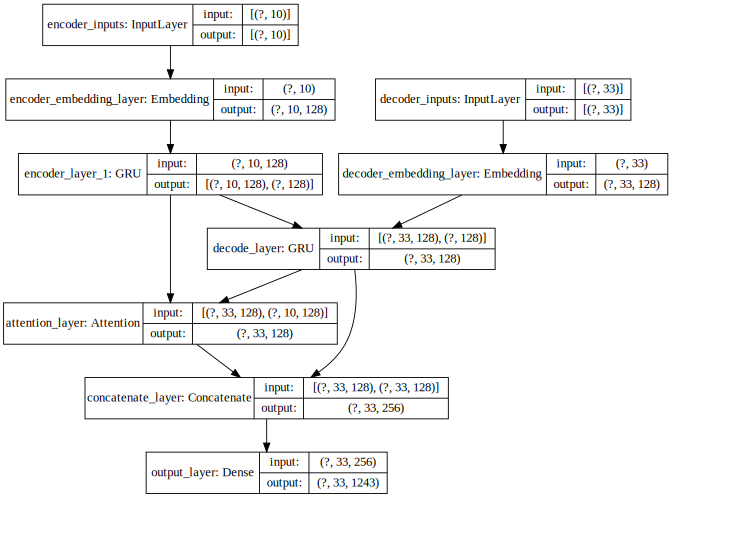

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Attention, Concatenate, Dense
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

# Encoder Input
encoder_inputs = Input(shape=(max_keywords,), name='encoder_inputs')

# Encoder Embedding Layer
encoder_embedding = Embedding(
    num_of_morphemes,
    embedding_dim,
    name='encoder_embedding_layer'
)(encoder_inputs)

# Encoder Layer
encoder_outputs, encoder_states = None, None
for i in range(encoder_layer_size):
    encoder_layer = GRU(
        units=hidden_size,
        return_sequences=True, return_state=True,
        dropout=dropout, recurrent_dropout=dropout,
        name='encoder_layer_' + str(i + 1)
    )
    encoder_outputs, encoder_states = encoder_layer(
        encoder_embedding if encoder_outputs is None else encoder_outputs
    )

# Decoder
decoder_inputs = Input(shape=(max_sentence_morphemes - 1,), name='decoder_inputs')

# Decoder Embedding Layer
decoder_embedding_layer = Embedding(
    num_of_morphemes,
    embedding_dim,
    name='decoder_embedding_layer'
)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# Decoder Layer
decoder_layer = GRU(
    hidden_size,
    return_sequences=True,
    dropout=dropout, recurrent_dropout=dropout / 2,
    name='decode_layer'
)
decoder_outputs = decoder_layer(
    decoder_embedding,
    initial_state=encoder_states
)

# Attention Layer
attention_layer = Attention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate the Result of Attention and the Hidden States of Decoder
decoder_concat_inputs = Concatenate(axis=-1, name='concatenate_layer')(
    [decoder_outputs, attention_outputs]
)

# Output Layer
output_layer = Dense(num_of_morphemes, activation=softmax, name='output_layer')
outputs = output_layer(decoder_concat_inputs)

# Define Model
model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=outputs,
    name='training_model'
)

# Compile
model.compile(
    optimizer=Adam(learning_rate=learning_late),
    loss=sparse_categorical_crossentropy
)

# Display Model Summary
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    keywords, sentences, test_size=0.33
)

In [17]:
history = model.fit(
    [x_train, y_train[:, :-1]], y_train[:, 1:],
    epochs=epochs, batch_size=batch_size,
    validation_data=([x_test, y_test[:, :-1]], y_test[:, 1:])
)

Train on 179 samples, validate on 89 samples
Epoch 1/5
179/179 [==============================] - 12s 69ms/sample - loss: 2.9963 - val_loss: 2.5958

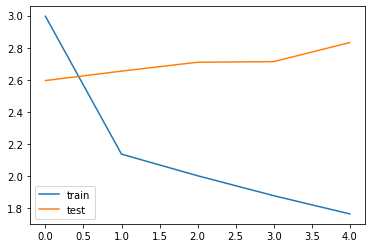

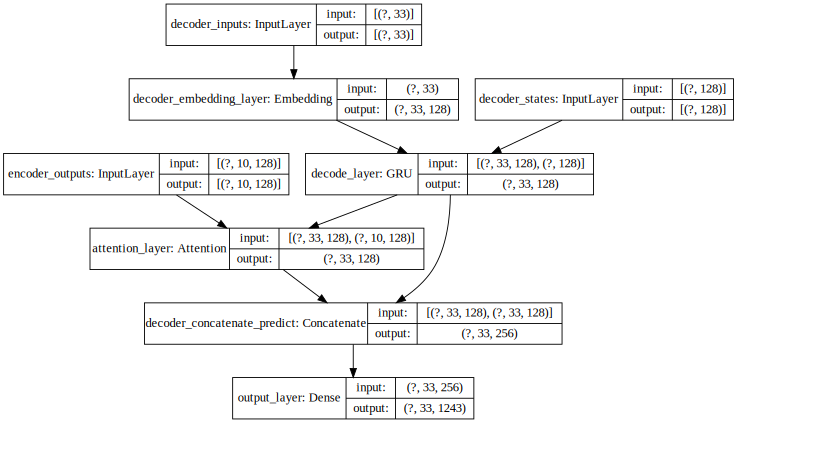

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# %%
# Define prediction model

# Define Encoder Model
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, encoder_states],
    name='encoder_model'
)

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(encoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

# %%
# Decoder
decoder_states_input = Input(
    shape=(hidden_size,),
    name='decoder_states'
)

decoder_embedding_predict = decoder_embedding_layer(decoder_inputs)
decoder_outputs_predict = decoder_layer(
    decoder_embedding_predict,
    initial_state=decoder_states_input
)

# Attention
decoder_hidden_states_input = Input(
    shape=(max_keywords, hidden_size),
    name='encoder_outputs'
)
attention_outputs_predict = attention_layer(
    [decoder_outputs_predict, decoder_hidden_states_input]
)
decoder_concat_predict = Concatenate(axis=-1, name='decoder_concatenate_predict')(
    [decoder_outputs_predict, attention_outputs_predict]
)

# Output Layer
outputs_predict = output_layer(decoder_concat_predict)

# Define Decoder Model
decoder_model = Model(
    [decoder_inputs, decoder_hidden_states_input, decoder_states_input],
    outputs_predict,
    name='decoder_model'
)

# You need to install graphviz! (sudo apt install graphviz or brew install graphviz)
SVG(model_to_dot(decoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [24]:
def encoding(keywords):
    tokenized = tokenizer.texts_to_sequences([keywords])[0]
    sequence = np.array([padding(tokenized, max_keywords)])
    return sequence

def predict(keywords):
    input_seq = encoding(keywords)
    e_out, e_h = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, max_sentence_morphemes - 1))
    target_seq[0, 0] = tokenizer.word_index[SOT]

    decoded_sentence = ''
    decoded_list = []
    len_sentence = 0
    while True:
        output_tokens = decoder_model.predict(
            [target_seq, e_out, e_h]
        )

        sampled_token_index = np.argmax(output_tokens[0, len_sentence, :])
        sampled_token = tokenizer.index_word[sampled_token_index]

        if sampled_token == EOT:
            break
        else:
            if sampled_token != PAD:
                decoded_sentence += ' ' + sampled_token
            decoded_list.append(sampled_token)
            len_sentence += 1

        if len_sentence >= max_sentence_morphemes - 1:
            break

        target_seq[0, len_sentence] = sampled_token_index

    return decoded_list

result = [predict(keywords) for keywords in data_keywords]
for i, res in enumerate(result):
    print('%-3d answer: \t' % i + str(data_sentences[i]))
    print('    predict: \t' + str(res))


0   answer: 	['sot', '1만', '여', '점', '이', '넘는', '유물', '과', '사진', '이', '한', '자리', '에서', '전시', '된다', 'eot']
    predict: 	['연합뉴스']
1   answer: 	['sot', '공원', '내', '에도', '암벽등반', '상설', '전', '시공간', '이', '공원', '방문자', '센터', '에', '들어선다', 'eot']
    predict: 	['현재', '역시', '1960년', '에', '에', '에', '에', '에', '하고', '하고', '있다']
2   answer: 	['sot', '비슷한', '사례', '가', '남미', '안데스', '의', '다른', '지역', '및', '티베트', '문화', '권', '등', '에서도', '확인', '됐다', 'eot']
    predict: 	['김상조', '이', '에도', '에도', '에도', '에도', '에도', '에도', '에도', '에도', '에', '에', '에', '을', '있다']
3   answer: 	['sot', '여기', '에', '아홉', '가지', '다', '채', '로운', '컬러', '와', '뒷', '면', '의', '그래픽', '포켓', '디자인', '으로', '스타일', '을', '더했다', 'eot']
    predict: 	['김상조', '이', '에도', '에도', '에도', '에도', '에', '에', '에', '에', '을', '있다']
4   answer: 	['sot', '이', '너', '브리프', '가', '있어', '워터', '스포츠', '활동', '에도', '편안하게', '착용', '할', '수', '있다', 'eot']
    predict: 	['롯데', '백화점', '이', '4일', '에', '에', '에', '한', '을', '을', '을', '을', '을', '을', '을', '을', '있다']
5   answer: 	['sot', '대부